In [ ]:
%%capture
!pip install tensorflow pyyaml librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%%capture
#!unzip "/content/drive/MyDrive/Bird-Detector.zip" -d /content/

!unzip -o -q "/content/drive/MyDrive/Bird-Detector.zip" -d /content/



In [ ]:
resnet4_specaug_cosinedecay

In [ ]:
!python3 Bird-Detector/src/model_cnn.py --tag resnet_specaug_adamw_warmup_cosine


2025-07-05 00:30:46.594120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751675446.614218   23035 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751675446.620543   23035 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-05 00:30:46.640867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-05 00:30:50.618090: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setti

In [ ]:
import os, yaml, numpy as np, tensorflow as tf
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Paths & config ---
BASE       = "/content/Bird-Detector"
CFG_PATH   = os.path.join(BASE, "src", "config.yaml")
DATA_DIR   = os.path.join(BASE, "data", "interim")
MODEL_DIR  = os.path.join(BASE, "models")

# load YAML
with open(CFG_PATH,"r") as f:
    cfg = yaml.safe_load(f)
SR     = cfg["audio"]["sample_rate"]
CHUNK  = cfg["audio"]["chunk_duration"]
N_MELS = cfg.get("n_mels",128)
FFT    = cfg.get("fft_size",1024)
HOP    = cfg.get("hop_length",512)
species = cfg["species"]
label_map = {sp:i for i,sp in enumerate(species)}

# --- 2) Gather & split WAVs (same seed/split as training) ---
wavs = sorted(glob(os.path.join(DATA_DIR,"**","*.wav"), recursive=True))
idxs = np.arange(len(wavs))
np.random.seed(42)
np.random.shuffle(idxs)
cut = int(0.8 * len(idxs))
val_idxs = idxs[cut:]
val_files = [wavs[i] for i in val_idxs]
val_labels = [
    label_map[ os.path.basename(p).rsplit("_",2)[0].replace("_"," ") ]
    for p in val_files
]

# --- 3) Decode→log-Mel helper (no augmentation) ---
def decode_and_mel(path):
    raw = tf.io.read_file(path)
    wav, _ = tf.audio.decode_wav(raw,
        desired_channels=1,
        desired_samples=SR*CHUNK
    )
    wav = tf.squeeze(wav, -1)
    spec = tf.abs(tf.signal.stft(wav, FFT, HOP))
    mel_wt = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=N_MELS,
        num_spectrogram_bins=spec.shape[-1],
        sample_rate=SR
    )
    mel = tf.tensordot(spec, mel_wt, 1)
    mel = tf.math.log(mel + 1e-6)
    mel = tf.transpose(mel)            # [n_mels, time]
    return mel[..., tf.newaxis]        # [n_mels, time, 1]

# --- 4) Load latest model matching your tag ---
TAG = "resnet4_specaug_cosinedecay"
models = [os.path.join(MODEL_DIR,f) for f in os.listdir(MODEL_DIR) if TAG in f]
if not models:
    raise FileNotFoundError("No model found with tag " + TAG)
model_path = max(models, key=os.path.getmtime)
print("⮕ Loading model:", model_path)
model = tf.keras.models.load_model(model_path)

# --- 5) Run inference on val set ---
preds, trues = [], []
for fp, lbl in zip(val_files, val_labels):
    mel = decode_and_mel(fp)
    prob = model.predict(mel[tf.newaxis,...], verbose=0)[0]
    preds.append(int(np.argmax(prob)))
    trues.append(int(lbl))

# --- 6) Confusion matrix + classification report ---
# find which classes actually appear in trues
unique_labels = sorted(set(trues))
label_names   = [species[i] for i in unique_labels]

# build confusion matrix only over those labels
cm = confusion_matrix(trues, preds, labels=unique_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(
    trues,
    preds,
    labels=unique_labels,
    target_names=label_names
))



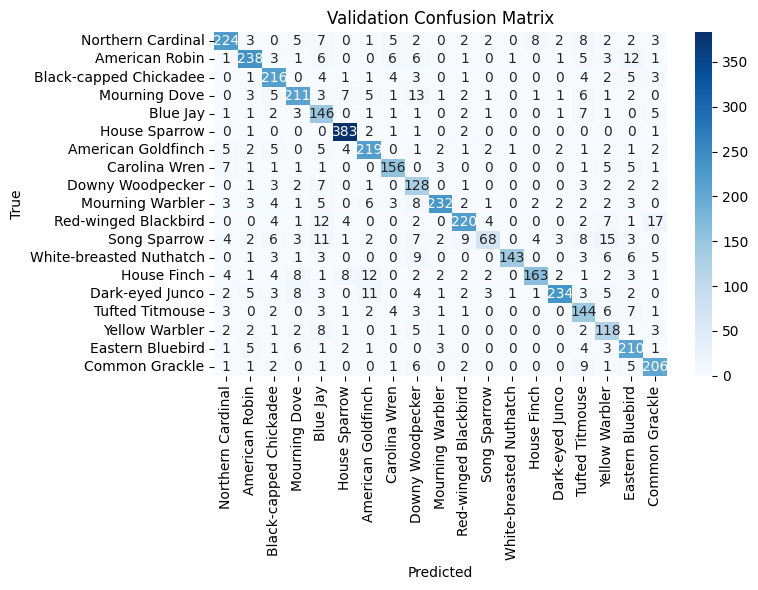


Classification Report:

                         precision    recall  f1-score   support

      Northern Cardinal       0.87      0.81      0.84       276
         American Robin       0.88      0.84      0.86       285
 Black-capped Chickadee       0.82      0.88      0.85       245
          Mourning Dove       0.83      0.80      0.82       263
               Blue Jay       0.64      0.84      0.73       173
          House Sparrow       0.93      0.98      0.95       391
     American Goldfinch       0.83      0.86      0.84       255
          Carolina Wren       0.85      0.86      0.85       182
       Downy Woodpecker       0.64      0.84      0.73       152
       Mourning Warbler       0.94      0.83      0.88       279
   Red-winged Blackbird       0.88      0.80      0.84       274
           Song Sparrow       0.81      0.46      0.59       148
White-breasted Nuthatch       0.98      0.79      0.88       180
            House Finch       0.91      0.75      0.82       218

In [ ]:
# --- 6) Confusion matrix + classification report (fixed) ---
from sklearn.metrics import classification_report, confusion_matrix

# find which classes actually appear in trues
unique_labels = sorted(set(trues))
label_names   = [species[i] for i in unique_labels]

# build confusion matrix only over those labels
cm = confusion_matrix(trues, preds, labels=unique_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(
    trues,
    preds,
    labels=unique_labels,
    target_names=label_names
))


In [ ]:
import glob
from google.colab import files

# find all keras checkpoints in the Bird-Detector/models folder
ckpts = sorted(glob.glob('Bird-Detector/models/*.keras'))
if not ckpts:
    raise RuntimeError("No .keras files found under Bird-Detector/models/")
latest = ckpts[-1]

print("Downloading:", latest)
files.download(latest)


Downloading: Bird-Detector/models/bird_resnet_resnet_specaug_adamw_warmup_cosine_20250705_002725.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%cd /content/Bird-Detector
!pip install -r requirements.txt

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 0) define your project root (where your `models/`, `outputs/` folders live)
PROJECT_ROOT = os.getcwd()   # or explicitly "/content/Bird-Detector"

# 1) your run‐tag
TAG = "resnet4_specaug_cosinedecay"

# 2) figure out which classes actually appear in your val set
unique_labels = sorted(set(trues))
label_names   = [species[i] for i in unique_labels]

# 3) compute confusion matrix
cm = confusion_matrix(trues, preds, labels=unique_labels)

# 4) save the plot
FIG_DIR = os.path.join(PROJECT_ROOT, "outputs", "figures")
os.makedirs(FIG_DIR, exist_ok=True)
fig_path = os.path.join(FIG_DIR, f"cm_{TAG}.png")

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(fig_path, dpi=150)
plt.close()
print("✅ Saved confusion matrix to", fig_path)

# 5) save the classification report
report = classification_report(
    trues,
    preds,
    labels=unique_labels,
    target_names=label_names
)

TEXT_DIR = os.path.join(PROJECT_ROOT, "outputs", "reports")
os.makedirs(TEXT_DIR, exist_ok=True)
rep_path = os.path.join(TEXT_DIR, f"report_{TAG}.txt")

with open(rep_path, "w") as f:
    f.write("Classification Report\n")
    f.write("====================\n\n")
    f.write(report)

print("✅ Saved classification report to", rep_path)


✅ Saved confusion matrix to /content/outputs/figures/cm_resnet4_specaug_cosinedecay.png
✅ Saved classification report to /content/outputs/reports/report_resnet4_specaug_cosinedecay.txt


# Git driven


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/Aysu-Maharramli/bird-detector.git


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'bird-detector'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 84 (delta 43), reused 62 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 66.02 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
%cd /content/Bird-Detector
!ln -s /content/Bird-Detector/data data


/content/Bird-Detector


In [ ]:
%cd /content/Bird-Detector/data
# this removes the symlink, not your actual files (it won’t descend into the real data/)
!rm data


/content/Bird-Detector/data
